In [45]:
LANGUAGE = 'bam'  # see ../settings/config.yml for other languages

## Setup & Initialization

### Imports

In [46]:
import yaml
from datasets import load_dataset, DatasetDict, concatenate_datasets
from transformers import AutoTokenizer
from contextlib import contextmanager
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import sys

In [47]:
@contextmanager
def extend_sys_path(path):
    if path not in sys.path:
        # Append the path to sys.path
        sys.path.append(path)
    try:
        # Execute code inside the 'with' statement
        yield
    finally:
        # Remove the path from sys.path
        if path in sys.path:
            sys.path.remove(path)

In [48]:
# Temporarily add module_path and import functions
module_path = os.path.abspath('../')

with extend_sys_path(module_path):
    from src.data.preprocess import (
        align_labels_for_many_records
    )

### Load resources (config and tokenizer)

In [49]:
# Reading config file
config = yaml.safe_load(open("../settings/config.yml"))

In [50]:
# Load indx-to-label_name mapping
label_mapping = config['label_mapping']
label_mapping

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-DATE',
 8: 'I-DATE'}

In [51]:
# Loading tokenizer
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

### Load dataset for selected language

In [52]:
# Loading dataset from HuggingFace
data = load_dataset(config['dataset'], LANGUAGE)
data

Found cached dataset masakhaner2 (/root/.cache/huggingface/datasets/masakhane___masakhaner2/bam/1.0.0/f5700a8b1468e7e03e17fe87897dca01d2eb8db3f67de132ada8396091a42963)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4462
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 638
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1274
    })
})

In [53]:
# Print out first record of the train split
data['train'][0]

{'id': '0',
 'tokens': ['Nin',
  'waati',
  'in',
  'na',
  ',',
  'a',
  'ka',
  'gɛlɛn',
  'mɔgɔ',
  "k'i",
  'dantigɛ',
  'a',
  'fatuli',
  'kun',
  'jɔnjɔnw',
  'kan',
  ',',
  "k'a",
  'da',
  'a',
  'kan',
  'a',
  'sababuw',
  'tolen',
  'bɛ',
  'dibi',
  'bɛ',
  '.'],
 'ner_tags': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

## EDA

### Label distribution

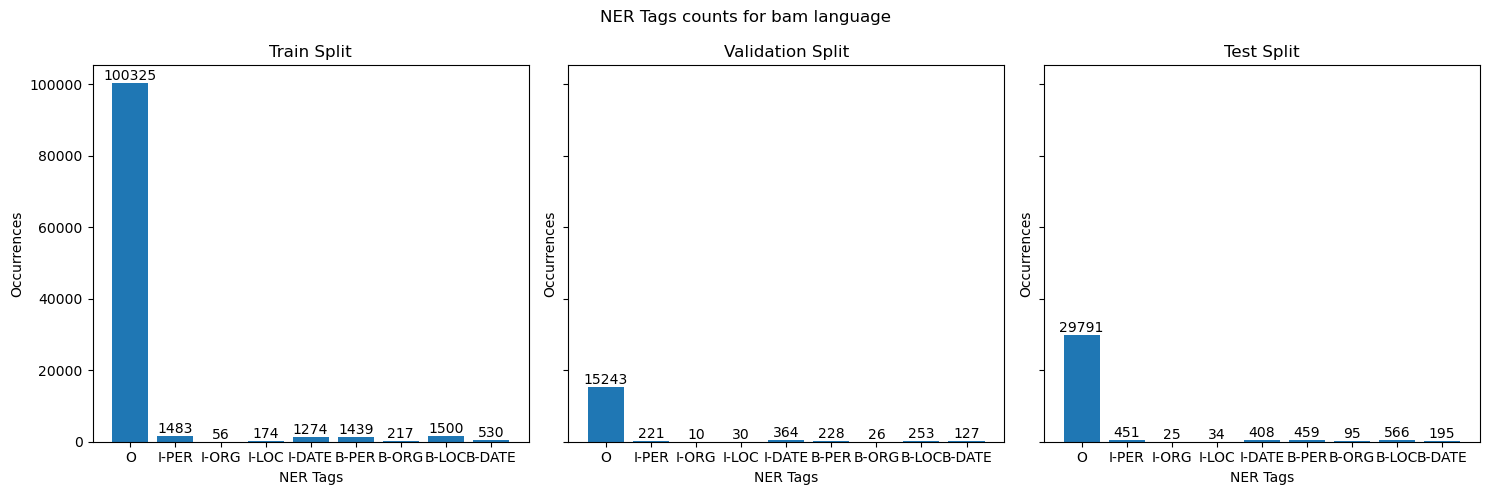

In [54]:
def count_labels_in_masakhaner(tags, label_mapping):
    """Counts labels in dataset and replaces labels indexes with label names"""
    labels_ = []
    # Iterate over each sentence 
    for sentence in tags:
        # Iterate over each label index in the sentence
        for label_idx in sentence:
            # Map the idx to its label and add to the list
            labels_.append(label_mapping[label_idx])

    # Count the occurrences of each label
    label_counts = Counter(labels_)
    return label_counts


fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, split in enumerate(['train', 'validation', 'test']):
    # Get NER tags counts for the current split
    ner_tags_counter = count_labels_in_masakhaner(data[split]['ner_tags'], label_mapping)

    # Sort values by label names 
    labels, values = zip(*sorted(ner_tags_counter.items(), key=lambda x: x[0], reverse=True))

    axes[i].bar(labels, values)
    # Add numbers on top of each bar
    for label, value in zip(labels, values):
        axes[i].text(label, value, str(value), ha='center', va='bottom')

    axes[i].set_xlabel('NER Tags')
    axes[i].set_ylabel('Occurrences')
    axes[i].set_title(f'{split.capitalize()} Split')

plt.suptitle(f'NER Tags counts for {LANGUAGE} language')
plt.tight_layout()
plt.show()

### Label distribution in a joined set (entities only)

Join labels from all sets, exclude non-entities.

In [55]:
labels = []

# Loop through each split of the dataset ('train', 'validation', 'test')
for i, split in enumerate(['train', 'validation', 'test']):
    # Extract the NER tags for the current split of the dataset
    tags_split = data[split]['ner_tags']

    # Iterate through each sentence (record) in the current split's NER tags
    for sentence in tags_split:
        # Add to the 'labels' list all tags from the sentence that are not equal to 0
        labels += [s for s in sentence if s != 0]

len(labels)

10165

In [56]:
# Get NER tags counts for the current split
ner_tags_counter = Counter([label_mapping[l] for l in labels])
ner_tags_counter

Counter({'B-LOC': 2319,
         'I-PER': 2155,
         'B-PER': 2126,
         'I-DATE': 2046,
         'B-DATE': 852,
         'B-ORG': 338,
         'I-LOC': 238,
         'I-ORG': 91})

In [57]:
# Normalize each count by dividing by the total count 
normalized_counts = {
    label: round(count / sum(ner_tags_counter.values()), 2) for label, count in ner_tags_counter.items()
}

normalized_counts

{'B-PER': 0.21,
 'I-PER': 0.21,
 'B-DATE': 0.08,
 'I-DATE': 0.2,
 'B-LOC': 0.23,
 'I-LOC': 0.02,
 'B-ORG': 0.03,
 'I-ORG': 0.01}

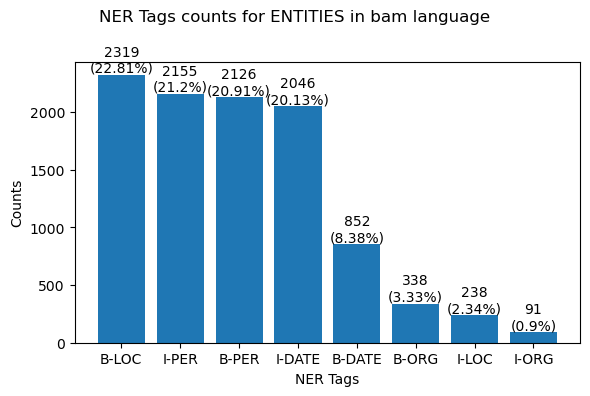

In [58]:
def plot_ner_tag_distribution(labels, label_mapping, language=LANGUAGE):
    """Plots the distribution of NER tags."""
    
    # Count occurrences of each label
    ner_tags_counter = Counter([label_mapping[l] for l in labels])
    # Calculate normalized counts
    normalized_counts = {
        label: round(count / sum(ner_tags_counter.values()) * 100, 2) 
        for label, count in ner_tags_counter.items()
    }

    # Plot
    fig, axes = plt.subplots(1, 1, figsize=(6, 4))

    # Sort values by count in descending order
    labels, values = zip(*sorted(ner_tags_counter.items(), key=lambda x: x[1], reverse=True))
    axes.bar(labels, values)

    # Add numbers on top of each bar
    for label, value in zip(labels, values):
        axes.text(label, value, f'{value}\n({normalized_counts[label]}%)', ha='center', va='bottom')

    axes.set_xlabel('NER Tags')
    axes.set_ylabel('Counts')
    plt.suptitle(f'NER Tags counts for ENTITIES in {language} language')
    plt.tight_layout()
    plt.show()


plot_ner_tag_distribution(labels, label_mapping)

## Sampling

### 1. Remove all records without any entities

In [59]:
def filter_records_with_entities(dataset):
    """Filter records that contain at least one entity."""
    return dataset.filter(lambda record: any(label != 0 for label in record['ner_tags']))

# Apply the filtering function to each split in the DatasetDict
filtered_data = DatasetDict({
    split: filter_records_with_entities(dataset)
    for split, dataset in data.items()
})

filtered_data

Loading cached processed dataset at /root/.cache/huggingface/datasets/masakhane___masakhaner2/bam/1.0.0/f5700a8b1468e7e03e17fe87897dca01d2eb8db3f67de132ada8396091a42963/cache-dccebf618497bebe.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/masakhane___masakhaner2/bam/1.0.0/f5700a8b1468e7e03e17fe87897dca01d2eb8db3f67de132ada8396091a42963/cache-393c96d4d3eccf6f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/masakhane___masakhaner2/bam/1.0.0/f5700a8b1468e7e03e17fe87897dca01d2eb8db3f67de132ada8396091a42963/cache-106b6307e4b47480.arrow


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2048
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 304
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 681
    })
})

### 2. Adding number of non-entities per record

In [60]:
def add_non_entity_count(record):
    """Add a count of non-entity tokens (labels != 0) to each record."""
    entity_count = sum(1 for label in record['ner_tags'] if label != 0)
    record['entity_count'] = entity_count
    
    # Overall number of labels 
    num_labels = sum(1 for label in record['ner_tags'] if label != -100)
    record['num_labels'] = num_labels
    
    # Proportion of entity_count to overall number of records
    record['% of entities'] = entity_count / num_labels
    
    return record

# Apply the function to each split in the DatasetDict
new_data = DatasetDict({
    split: dataset.map(add_non_entity_count)
    for split, dataset in filtered_data.items()
})

new_data

Loading cached processed dataset at /root/.cache/huggingface/datasets/masakhane___masakhaner2/bam/1.0.0/f5700a8b1468e7e03e17fe87897dca01d2eb8db3f67de132ada8396091a42963/cache-7994e49bccfee291.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/masakhane___masakhaner2/bam/1.0.0/f5700a8b1468e7e03e17fe87897dca01d2eb8db3f67de132ada8396091a42963/cache-e1286eafac853843.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/masakhane___masakhaner2/bam/1.0.0/f5700a8b1468e7e03e17fe87897dca01d2eb8db3f67de132ada8396091a42963/cache-e00d570914cf3e94.arrow


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'entity_count', 'num_labels', '% of entities'],
        num_rows: 2048
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'entity_count', 'num_labels', '% of entities'],
        num_rows: 304
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'entity_count', 'num_labels', '% of entities'],
        num_rows: 681
    })
})

### 3. Concatenate train, test, val split

In [61]:
# Concatenate all splits into a single dataset
merged_data = concatenate_datasets([dataset for dataset in new_data.values()])
merged_data

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'entity_count', 'num_labels', '% of entities'],
    num_rows: 3033
})

### 4. Sort and select records

1. Select records where proportion of entities is in a specified range.

In [62]:
sorted_dataset = merged_data.filter(lambda example: 0.05 < example['% of entities'] < 0.5) \
    .sort('entity_count', reverse=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/masakhane___masakhaner2/bam/1.0.0/f5700a8b1468e7e03e17fe87897dca01d2eb8db3f67de132ada8396091a42963/cache-adc0dac6c5078aed.arrow
Loading cached sorted indices for dataset at /root/.cache/huggingface/datasets/masakhane___masakhaner2/bam/1.0.0/f5700a8b1468e7e03e17fe87897dca01d2eb8db3f67de132ada8396091a42963/cache-66ffe587e43ca269.arrow


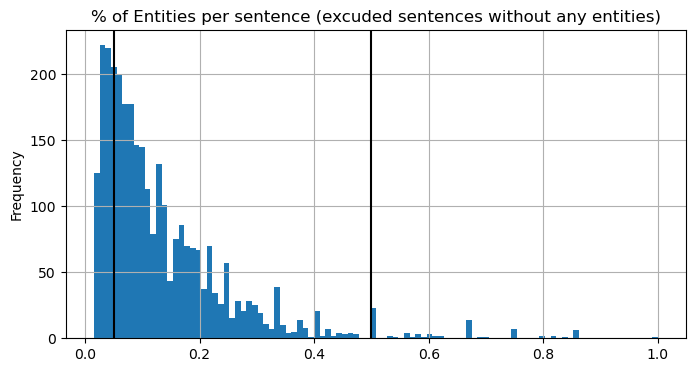

In [63]:
percent_of_entities = [example['% of entities'] for example in merged_data]

# Plotting the histogram
plt.figure(figsize=(8, 4))  
plt.hist(percent_of_entities, bins=100, alpha=1) 
plt.title("% of Entities per sentence (excuded sentences without any entities)")
plt.ylabel('Frequency')
plt.axvline(x=0.05, color='black')
plt.axvline(x=0.5, color='black')
plt.grid(True) 
plt.show()

2. Sample using weighted probability

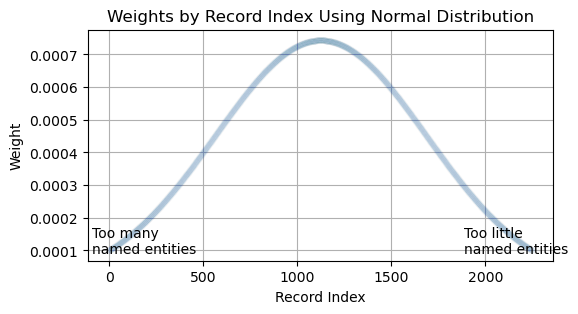

In [64]:
num_records = len(sorted_dataset)  

mu = num_records / 2  # Mean of the dataset
sigma = num_records / 4  # Dataset spread (higher number means tighter distribution)

# Generate weights using a normal distribution function
x = np.arange(num_records)
weights = np.exp(-(x - mu)**2 / (2 * sigma**2))

# Normalize weights to sum to 1
weights /= weights.sum()

# Plotting the weights
plt.figure(figsize=(6, 3))
plt.plot(weights, marker='o', linestyle='-', markersize=4, alpha=0.01)
plt.title('Weights by Record Index Using Normal Distribution')
plt.xlabel('Record Index')
plt.ylabel('Weight')
plt.grid(True)

# Get current axis limits
x_lim = plt.xlim()
y_lim = plt.ylim()

# Add text to the bottom left corner
plt.text(x_lim[0]*0.8, y_lim[0]*1.2, 'Too many \nnamed entities', 
         verticalalignment='bottom', horizontalalignment='left')

# Add text to the bottom right corner
plt.text(x_lim[1]*0.8, y_lim[0]*1.2, 'Too little \nnamed entities', 
         verticalalignment='bottom', horizontalalignment='left')

plt.show()

In [65]:
def weighted_random_selection(dataset, N, decay_rate=0.005, seed=42):
    """Select N records randomly with decreasing probability from the SORTED dataset."""
    np.random.seed(seed)  # For reproducibility

    # Number of records in the dataset
    num_records = len(dataset)

    mu = num_records / 2
    sigma = num_records / 4

    # Generate weights using a normal distribution function
    x = np.arange(num_records)
    weights = np.exp(-(x - mu)**2 / (2 * sigma**2))
    # Normalize weights to sum to 1
    weights /= weights.sum()

    # Select N indices based on the weights
    selected_indices = np.random.choice(num_records, size=N, replace=False, p=weights)
    # Select records from the dataset based on the chosen indices
    selected_records = dataset.select(selected_indices)

    return selected_records


N = 100  # Number of records to be selected
top_n_records = weighted_random_selection(sorted_dataset, N)

In [66]:
top_n_records

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'entity_count', 'num_labels', '% of entities'],
    num_rows: 100
})

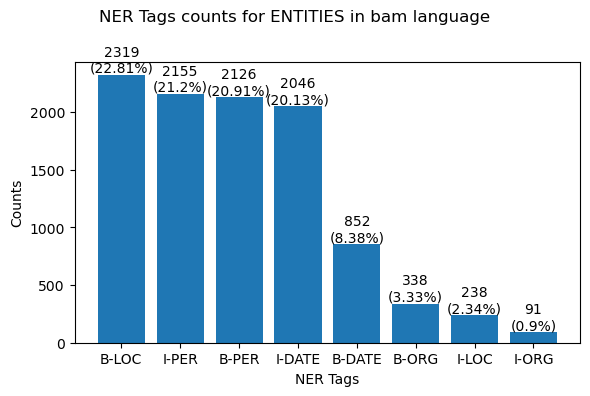

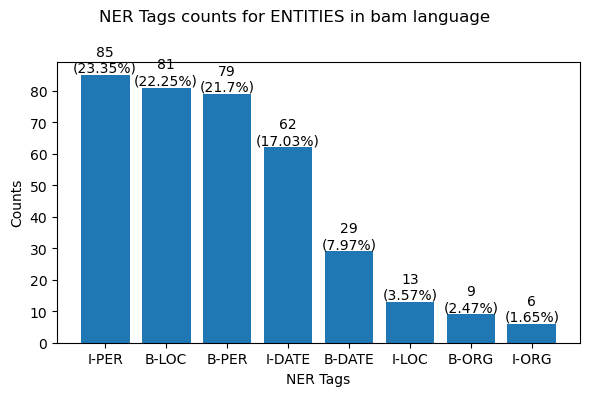

In [67]:
# Plot distribution of entities in the initial dataset
plot_ner_tag_distribution(labels, label_mapping)

# Plot distribution of entities in the sampled subset
labels_top_n = [tag for sentence in top_n_records['ner_tags'] for tag in sentence if tag != 0]
plot_ner_tag_distribution(labels_top_n, label_mapping)

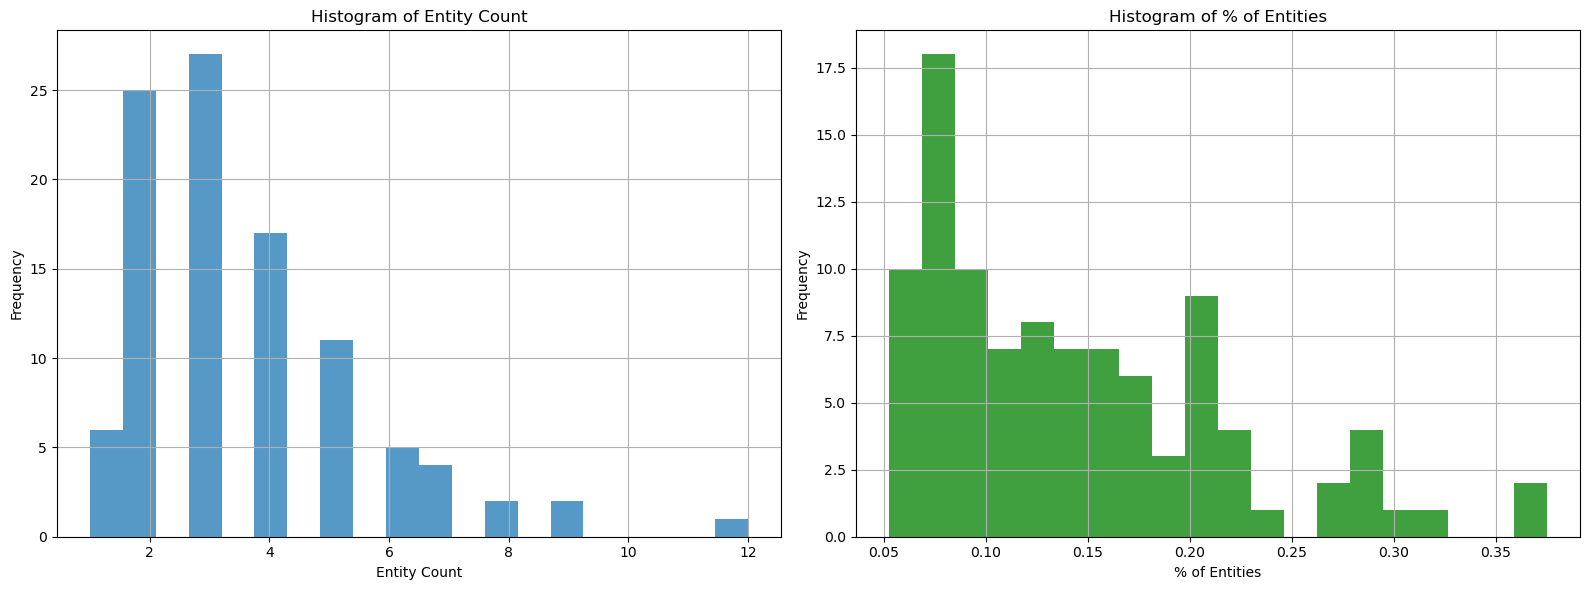

In [68]:
entity_count = top_n_records['entity_count']
percent_of_entities = top_n_records['% of entities']

# Set up a figure with two subplots side by side
plt.figure(figsize=(16, 6))

# Plot 1: Number of Entities
plt.subplot(1, 2, 1)  
plt.hist(entity_count, bins=20, alpha=0.75)
plt.title("Histogram of Entity Count")
plt.xlabel('Entity Count')
plt.ylabel('Frequency')
plt.grid(True)

# Plot 2: Percentage of Entities
plt.subplot(1, 2, 2)  
plt.hist(percent_of_entities, bins=20, alpha=0.75, color='green')
plt.title("Histogram of % of Entities")
plt.xlabel('% of Entities')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

In [69]:
' '.join(top_n_records[0]['tokens'])

"N'a ka BEYEPESE ye a jifa kɔnɔ , Mori Sumano bilala ka taa Sikaso Bakurubakalan Kalanfɛɛrɛ Ɲɛɲininiyɔrɔ ( IPEYEZE ) la ."

In [70]:
' '.join(top_n_records[1]['tokens'])

'An kunnafonibagaw ka fɔ la , Bamakɔ arɔndiseman 1ɔlɔ polisiw ka'

In [71]:
' '.join(top_n_records[2]['tokens'])

'Ngaradabaga , kabini waati janba , min ye kanu don ni fanga ye ATETE tile la ani IBEKA , yecogo jɛlen ani hakilimaya ka kan ka kɛ o la fɛn na , jamana mago bɛ min na .'

### Testing sampling based on the distribution of number of entities per sample

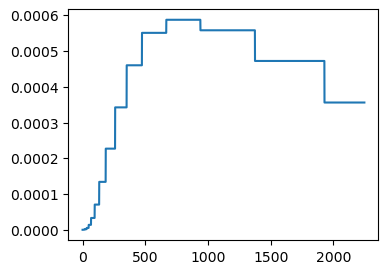

In [72]:
def weighted_random_selection_normal_entity_count(dataset, N, seed=42):
    np.random.seed(seed)  # For reproducibility

    # Extract entity counts from the dataset
    entity_counts = np.array([example['entity_count'] for example in dataset])

    # Calculate the mean (mu) and standard deviation (sigma) for entity counts
    mu = np.mean(entity_counts)
    sigma = np.std(entity_counts)

    # Calculate weights using a normal distribution formula
    weights = np.exp(-((entity_counts - mu) ** 2) / (2 * sigma ** 2))

    # Normalize weights to sum to 1
    weights /= np.sum(weights)
    plt.figure(figsize=(4,3))
    plt.plot(weights)
    plt.show()

    # Number of records in the dataset
    num_records = len(dataset)

    # Select N indices based on the weights
    selected_indices = np.random.choice(num_records, size=N, replace=False, p=weights)

    # Select records from the dataset based on the chosen indices
    selected_records = dataset.select(selected_indices)

    return selected_records


N = 100  # Number of records to be selected
top_n_records_c = weighted_random_selection_normal_entity_count(sorted_dataset, N)

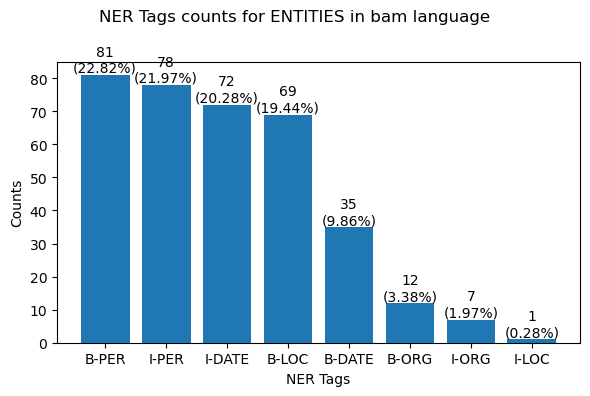

In [73]:
# Plot distribution of entities in the sampled subset
labels_top_n = [tag for sentence in top_n_records_c['ner_tags'] for tag in sentence if tag != 0]
plot_ner_tag_distribution(labels_top_n, label_mapping)

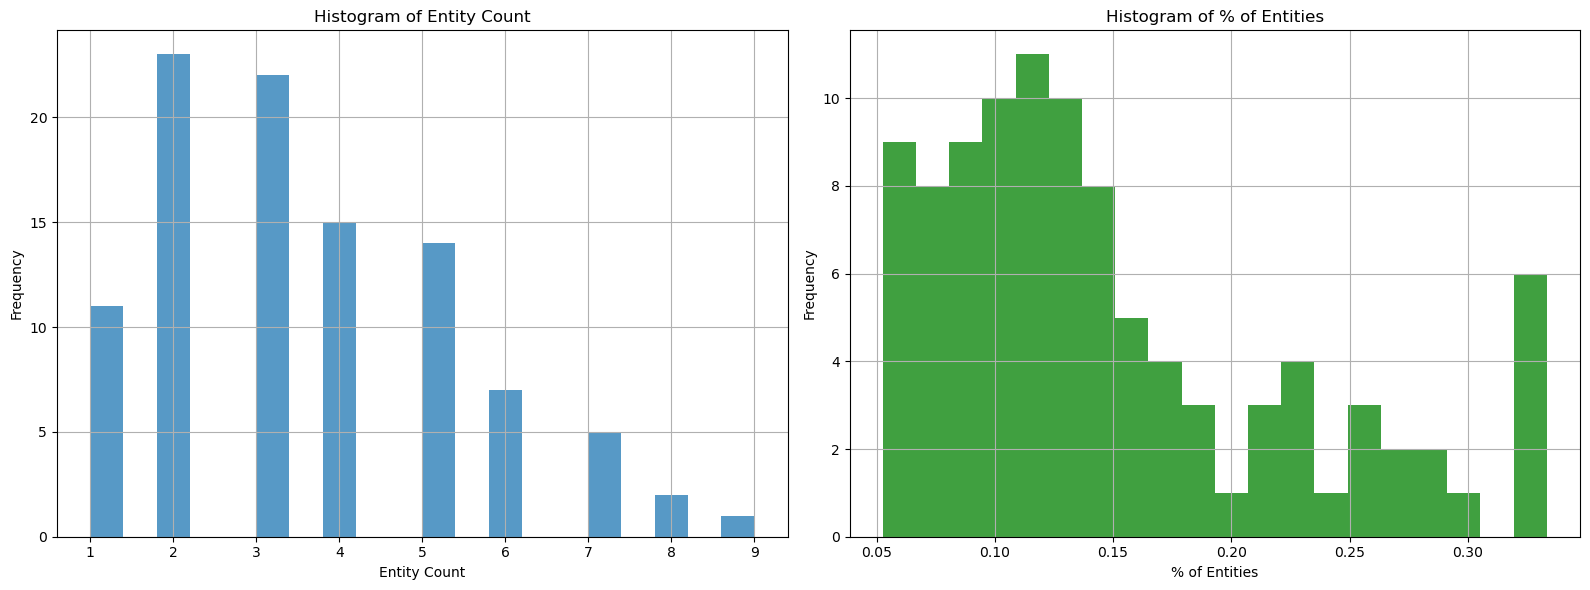

In [74]:
plt.figure(figsize=(16, 6))

# Plot 1: Number of Entities
plt.subplot(1, 2, 1) 
plt.hist(top_n_records_c['entity_count'], bins=20, alpha=0.75)
plt.title("Histogram of Entity Count")
plt.xlabel('Entity Count')
plt.ylabel('Frequency')
plt.grid(True)

# Plot 2: Percentage of Entities
plt.subplot(1, 2, 2)  
plt.hist(top_n_records_c['% of entities'], bins=20, alpha=0.75, color='green')
plt.title("Histogram of % of Entities")
plt.xlabel('% of Entities')
plt.ylabel('Frequency')
plt.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()